In [ ]:
import warnings
from pprint import pprint
warnings.filterwarnings('ignore')

In [ ]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv('./credential/cred.env')

# Get the API key from the environment variables
api_key = os.environ.get("API_KEY")

# Check if the API key was found
if api_key:
  print("API Key loaded successfully.")
else:
  print("API Key not found in the environment variables.")
os.environ["OPENAI_API_KEY"] = api_key

API Key loaded successfully.


# Chapter 7. Agents II

บทที่ 6 ได้แนะนำสถาปัตยกรรมตัวแทน ซึ่งเป็นสถาปัตยกรรม LLM ที่ทรงพลังที่สุดที่เราได้เห็นจนถึงขณะนี้ เป็นการยากที่จะพูดเกินจริงถึงศักยภาพของการผสมผสานนี้ของการเขียนพรอมต์แบบ chain-of-thought การใช้เครื่องมือ และการวนซ้ำ

**บทนี้กล่าวถึงส่วนขยายสองส่วนของสถาปัตยกรรมตัวแทนที่ปรับปรุงประสิทธิภาพสำหรับกรณีการใช้งานบางอย่าง:**

- **Reflection (การสะท้อนกลับ)**
การนำอีกหน้าหนึ่งจากคลังเก็บรูปแบบการคิดของมนุษย์ สิ่งนี้เกี่ยวกับการให้โอกาสแอปพลิเคชัน LLM ของคุณในการวิเคราะห์ผลลัพธ์และตัวเลือกในอดีต พร้อมกับความสามารถในการจดจำการสะท้อนกลับจากการวนซ้ำในอดีต

- **Multi-agent (หลายตัวแทน)**
เช่นเดียวกับที่ทีมสามารถบรรลุเป้าหมายได้มากกว่าบุคคลคนเดียว มีปัญหาบางอย่างที่สามารถแก้ไขได้ดีที่สุดโดยทีมของตัวแทน LLM

มาเริ่มต้นด้วยการสะท้อนกลับกัน

# Reflection
**การสะท้อนกลับ**

เทคนิคการเขียนพรอมต์อย่างหนึ่งที่เรายังไม่ได้กล่าวถึงคือ การสะท้อนกลับ (หรือที่เรียกว่าการวิจารณ์ตนเอง) การสะท้อนกลับคือการสร้างลูประหว่างพรอมต์ผู้สร้างและพรอมต์ผู้แก้ไข สิ่งนี้สะท้อนกระบวนการสร้างสรรค์สำหรับสิ่งประดิษฐ์ที่สร้างโดยมนุษย์หลายอย่าง เช่น บทนี้ที่คุณกำลังอ่านอยู่ ซึ่งเป็นผลมาจากการโต้ตอบระหว่างผู้เขียน ผู้ตรวจทาน และบรรณาธิการจนกว่าทุกคนจะพอใจกับผลิตภัณฑ์ขั้นสุดท้าย

เช่นเดียวกับเทคนิคการเขียนพรอมต์หลายอย่างที่เราได้เห็นมาจนถึงตอนนี้ การสะท้อนกลับสามารถรวมกับเทคนิคอื่นๆ เช่น chain-of-thought และการเรียกใช้งานเครื่องมือได้ ในส่วนนี้ เราจะดูการสะท้อนกลับแบบแยกส่วน เพื่อความชัดเจน

สามารถเปรียบเทียบได้กับโหมดการคิดของมนุษย์ที่เรียกว่า ระบบ 1 (ตอบสนองหรือสัญชาตญาณ) และระบบ 2 (มีระเบียบวิธีและมีการสะท้อนกลับ) ซึ่ง Daniel Kahneman ได้แนะนำครั้งแรกในหนังสือ Thinking, Fast and Slow (Farrar, Straus and Giroux, 2011) เมื่อนำไปใช้ถูกต้อง การวิจารณ์ตนเองสามารถช่วยให้แอปพลิเคชัน LLM เข้าใกล้สิ่งที่คล้ายคลึงกับพฤติกรรมของระบบ 2 ได้มากขึ้น ดังรูป

---

<img align="top" src="./pics/Figure7-1.png"     style=" width:380px; padding: 10px; " >

---



เราจะนำการสะท้อนกลับไปใช้เป็นกราฟที่มีสองโหนด: `generate` และ `reflect` กราฟนี้จะมีภารกิจในการเขียนเรียงความสามย่อหน้า โดยโหนด generate เขียนหรือแก้ไขร่างของเรียงความ และ `reflect` เขียนคำวิจารณ์เพื่อแจ้งการแก้ไขครั้งถัดไป เราจะเรียกใช้ลูปจำนวนครั้งคงที่ แต่รูปแบบที่แตกต่างกันของเทคนิคนี้คือการให้โหนด `reflect` ตัดสินใจว่าจะเสร็จสิ้นเมื่อใด

มาดูกันว่ามันมีลักษณะอย่างไร:

In [ ]:
from typing import Annotated, TypedDict

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    HumanMessage,
    SystemMessage,
)
from langchain_openai import ChatOpenAI

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages

model = ChatOpenAI()

class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

generate_prompt = SystemMessage(
    "You are an essay assistant tasked with writing excellent 3-paragraph essays."
    " Generate the best essay possible for the user's request."
    " If the user provides critique, respond with a revised version of your previous attempts."
)

def generate(state: State) -> State:
    answer = model.invoke([generate_prompt] + state["messages"])
    return {"messages": [answer]}

reflection_prompt = SystemMessage(
    """You are a teacher grading an essay submission. Generate critique and
        recommendations for the user's submission."""
    """ Provide detailed recommendations, including requests for length, depth,
        style, etc."""
)

def reflect(state: State) -> State:
    # Invert the messages to get the LLM to reflect on its own output
    cls_map = {AIMessage: HumanMessage, HumanMessage: AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [reflection_prompt, state["messages"][0]] + [
        cls_map[msg.__class__](content=msg.content) for msg in state["messages"][1:]
    ]
    answer = model.invoke(translated)
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=answer.content)]}

def should_continue(state: State):
    if len(state["messages"]) > 6:
        # End after 3 iterations, each with 2 messages
        return END
    else:
        return "reflect"

builder = StateGraph(State)
builder.add_node("generate", generate)
builder.add_node("reflect", reflect)
builder.add_edge(START, "generate")
builder.add_conditional_edges("generate", should_continue)
builder.add_edge("reflect", "generate")

graph = builder.compile()

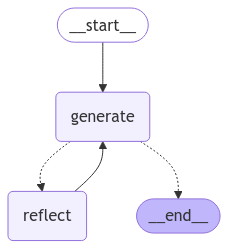

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

สังเกตว่าโหนด `reflect` หลอกให้ LLM คิดว่ากำลังวิจารณ์เรียงความที่เขียนโดยผู้ใช้ และในเวลาเดียวกัน โหนด `generate` ถูกทำให้คิดว่าคำวิจารณ์มาจากผู้ใช้
- การลวงนี้จำเป็นเนื่องจาก LLM ที่ได้รับการปรับแต่งด้วยการสนทนาได้รับการฝึกอบรมบนคู่ของข้อความระหว่างมนุษย์กับ AI ดังนั้น ลำดับของข้อความจำนวนมากจากผู้เข้าร่วมรายเดียวกันจะส่งผลให้ประสิทธิภาพการทำงานต่ำ

**อีกสิ่งหนึ่งที่ควรทราบ:**คุณอาจคาดหวังว่าจุดสิ้นสุดจะเกิดขึ้นหลังจากขั้นตอนการแก้ไข แต่ในสถาปัตยกรรมนี้เรามี**จำนวน**การวนซ้ำของลูป `generate-reflect` ที่กำหนดไว้ ดังนั้นเราจึงสิ้นสุดหลังจาก generate (เพื่อให้ชุดการแก้ไขล่าสุดที่ร้องขอได้รับการจัดการ) รูปแบบหนึ่งของสถาปัตยกรรมนี้จะแทนที่ให้ขั้นตอนการสะท้อนกลับตัดสินใจสิ้นสุดกระบวนการ (เมื่อไม่มีความคิดเห็นเพิ่มเติม)

มาดูกันว่าหนึ่งในคำวิจารณ์มีลักษณะอย่างไร:

```
{
    'messages': [
        HumanMessage(content='Your essay on the topicality of "The Little Prince"
            and its message in modern life is well-written and insightful. You
            have effectively highlighted the enduring relevance of the book\'s
            themes and its importance in today\'s society. However, there are a
            few areas where you could enhance your essay:\n\n1. **Depth**:
            While you touch upon the themes of cherishing simple joys,
            nurturing connections, and understanding human relationships,
            consider delving deeper into each of these themes. Provide specific
            examples from the book to support your points and explore how these
            themes manifest in contemporary life.\n\n2. **Analysis**: Consider
            analyzing how the book\'s messages can be applied to current
            societal issues or personal experiences. For instance, you could
            discuss how the Little Prince\'s perspective on materialism relates
            to consumer culture or explore how his approach to relationships
            can inform interpersonal dynamics in the digital age.\n\n3.
            **Length**: Expand on your ideas by adding more examples,
            discussing counterarguments, or exploring the cultural impact of
            "The Little Prince" in different parts of the world. This will
            enrich the depth of your analysis and provide a more comprehensive
            understanding of the book\'s relevance.\n\n4. **Style**: Your essay
            is clear and well-structured. To enhance the engagement of your
            readers, consider incorporating quotes from the book to illustrate
            key points or including anecdotes to personalize your analysis.
            \n\n5. **Conclusion**: Conclude your essay by summarizing the
            enduring significance of "The Little Prince" and how its messages
            can inspire positive change in modern society. Reflect on the
            broader implications of the book\'s themes and leave the reader
            with a lasting impression.\n\nBy expanding on your analysis,
            incorporating more examples, and deepening your exploration of the
            book\'s messages, you can create a more comprehensive and
            compelling essay on the topicality of "The Little Prince" in modern
            life. Well done on your thoughtful analysis, and keep up the good
            work!', id='70c22b1d-ec96-4dc3-9fd0-d2c6463f9e2c'),
    ],
}
```

และผลลัพธ์สุดท้าย:
```
{
    'messages': [
        AIMessage(content='"The Little Prince" by Antoine de Saint-Exupéry stands
            as a timeless masterpiece that continues to offer profound insights
            into human relationships and values, resonating with readers across
            generations. The narrative of the Little Prince\'s travels and
            encounters with a myriad of characters serves as a rich tapestry of
            allegorical representations, inviting readers to delve deeper into
            the complexities of interpersonal connections and the essence of
            existence. Through critical analysis of the Prince\'s interactions
            with characters like the Fox and the Rose, readers can glean
            valuable lessons on empathy, understanding, and the significance of
            genuine human connections. By examining these encounters through a
            critical lens and drawing parallels to real-life scenarios, the
            book\'s messages come to life with renewed relevance and depth.
            \n\nIn today\'s fast-paced and interconnected world, the themes
            explored in "The Little Prince" offer poignant reflections on the
            challenges and opportunities of modern society. By integrating
            contemporary examples and case studies that illustrate how the
            book\'s principles manifest in current societal trends and
            interpersonal dynamics, readers can better appreciate the enduring
            relevance of the Prince\'s timeless wisdom. Through a comparative
            analysis that juxtaposes the struggles faced by the characters in
            the book with the complexities of today\'s world, readers can gain
            a deeper understanding of how the book\'s messages transcend time
            and offer universal truths that guide individuals in navigating the
            intricacies of human relationships and societal dynamics.
            \n\nMoreover, the global impact of "The Little Prince" underscores
            its universal resonance and cultural significance. By exploring how
            the book\'s themes have resonated with audiences worldwide and how
            cultural interpretations shape the understanding of its messages,
            readers can appreciate the depth and breadth of Saint-Exupéry\'s
            work. As readers reflect on the book\'s enduring relevance and the
            lessons it imparts, they are encouraged to actively apply these
            insights in their daily lives, fostering a more empathetic and
            compassionate society. By offering a call to action that prompts
            readers to embrace the book\'s teachings and integrate them into
            their interactions and relationships, the essay aims to inspire
            individuals to embody the spirit of the Little Prince and cultivate
            meaningful connections that transcend boundaries and enrich lives
            in a rapidly changing world.', response_metadata={'token_usage':
            {'completion_tokens': 420, 'prompt_tokens': 2501, 'total_tokens':
            2921}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None,
            'finish_reason': 'stop', 'logprobs': None},
            id='run-2e8f9f13-f625-4820-9c8b-b64e1c23daa2-0', usage_metadata=
            {'input_tokens': 2501, 'output_tokens': 420, 'total_tokens': 2921}),
    ],
}
```

In [ ]:
user_prompt = HumanMessage(content="Write a 3-paragraph essay about the importance of kindness. (make sure your output is thai language)")
result = graph.invoke({"messages": [user_prompt]})
result


การสะท้อนกลับประเภทง่ายๆ นี้อาจช่วยปรับปรุงประสิทธิภาพได้บางครั้ง โดยการให้ LLM มีโอกาสปรับปรุงผลลัพธ์หลายครั้ง และโดยการให้โหนด `reflect` รับบทบาทที่แตกต่างออกไปขณะวิจารณ์ผลลัพธ์

มีรูปแบบที่เป็นไปได้หลายอย่างของสถาปัตยกรรมนี้ สำหรับหนึ่งในนั้น เราสามารถรวมขั้นตอนการสะท้อนกลับเข้ากับสถาปัตยกรรมตัวแทนของ บทที่ 6
- โดยเพิ่มเป็นโหนดสุดท้ายก่อนส่งเอาต์พุตไปยังผู้ใช้ สิ่งนี้จะทำให้คำวิจารณ์ปรากฏว่ามาจากผู้ใช้ (ดังที่กล่าวไว้ข้างต้น)
- และให้โอกาสแอปพลิเคชันในการปรับปรุงผลลัพธ์ขั้นสุดท้ายโดยไม่ต้องมีการแทรกแซงโดยตรงจากผู้ใช้ เห็นได้ชัดว่าวิธีนี้อาจส่งผลให้เกิดเวลาแฝงที่สูงขึ้น

ในบางกรณีการใช้งาน อาจเป็นประโยชน์ในการอ้างอิงคำวิจารณ์ด้วยข้อมูลภายนอก ตัวอย่างเช่น หากคุณกำลังเขียนตัวแทนการสร้างโค้ด คุณอาจมีขั้นตอนก่อน `reflect` ที่จะเรียกใช้โค้ดผ่าน `linter` หรือคอมไพล์เลอร์ และรายงานข้อผิดพลาดใดๆ เป็นอินพุตไปยัง `reflect`



**เคล็ดลับ** : เมื่อใดก็ตามที่วิธีนี้เป็นไปได้ เราขอแนะนำให้ลองใช้ เนื่องจากมีแนวโน้มที่จะเพิ่มคุณภาพของผลลัพธ์ขั้นสุดท้าย

# Subgraphs in LangGraph


ก่อนที่เราจะเจาะลึกรายละเอียดสถาปัตยกรรมหลายตัวแทน มาดูแนวคิดทางเทคนิคที่สำคัญใน LangGraph ที่ช่วยให้สามารถทำได้ Subgraphs คือ**กราฟที่ใช้เป็นส่วนหนึ่งของกราฟอื่นๆ** ต่อไปนี้คือกรณีการใช้งานบางอย่างสำหรับ subgraphs:

- การสร้างระบบหลายตัวแทน (กล่าวถึงในหัวข้อถัดไป)

- เมื่อคุณต้องการนำชุดโหนดกลับมาใช้ใหม่ในหลายกราฟ คุณสามารถกำหนดโหนดเหล่านั้นเพียงครั้งเดียวใน subgraph จากนั้นจึงใช้ในกราฟหลักหลายตัว

- เมื่อคุณต้องการให้ทีมต่างๆ ทำงานในส่วนต่างๆ ของกราฟอย่างอิสระ คุณสามารถกำหนดแต่ละส่วนเป็น subgraph และตราบใดที่อินเทอร์เฟซ subgraph (รูปแบบอินพุตและเอาต์พุต) เป็นไปตามที่กำหนด กราฟหลักสามารถสร้างได้โดยไม่ทราบรายละเอียดใดๆ ของ subgraph

**มีสองวิธีในการเพิ่มโหนด subgraph ลงในกราฟหลัก:**

- **เพิ่มโหนดที่เรียกใช้งาน subgraph โดยตรง**
วิธีนี้มีประโยชน์เมื่อกราฟหลักและ subgraph ใช้คีย์สถานะร่วมกัน และคุณไม่จำเป็นต้องแปลงสถานะในระหว่างทางเข้าหรือออก

- **เพิ่มโหนดที่มีฟังก์ชันที่เรียกใช้งาน subgraph**
วิธีนี้มีประโยชน์เมื่อกราฟหลักและ subgraph มีรูปแบบสถานะที่แตกต่างกัน และคุณจำเป็นต้องแปลงสถานะก่อนหรือหลังการเรียกใช้งาน subgraph

มาดูกันทีละวิธี

## Calling a Subgraph Directly


**วิธีที่ง่ายที่สุดในการสร้างโหนด subgraph คือการแนบ subgraph โดยตรงเป็นโหนด**
- เมื่อทำเช่นนั้น สิ่งสำคัญคือกราฟหลักและ subgraph ต้องใช้คีย์สถานะร่วมกัน เนื่องจากคีย์ที่ใช้ร่วมกันเหล่านั้นคือสิ่งที่พวกเขาสามารถใช้เพื่อสื่อสาร (หากกราฟและ subgraph ของคุณไม่มีคีย์ใดๆ ที่ใช้ร่วมกัน ให้ดูส่วนถัดไป)

**หมายเหตุ:**
- หากคุณส่งผ่านคีย์พิเศษไปยังโหนด subgraph (นั่นคือ นอกเหนือจากคีย์ที่ใช้ร่วมกัน) คีย์พิเศษเหล่านั้นจะถูกโหนด subgraph ละเว้น
- ในทำนองเดียวกัน หากคุณส่งคืนคีย์พิเศษจาก subgraph คีย์พิเศษเหล่านั้นจะถูกกราฟหลักละเว้น

มาดูกันว่ามันทำงานอย่างไรในทางปฏิบัติ:

In [ ]:
from langgraph.graph import START, StateGraph, END
from typing import TypedDict

class State(TypedDict):
    foo: str # this key is shared with the subgraph

class SubgraphState(TypedDict):
    foo: str # this key is shared with the parent graph
    bar: str

# Define subgraph
def subgraph_node(state: SubgraphState):
    # note that this subgraph node can communicate with the parent graph via the shared "foo" key
    return {"foo": state["foo"] + "bar"}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node)
# Add an edge to connect START to subgraph_node to initiate the workflow
subgraph_builder.add_edge(START, "subgraph_node")
subgraph = subgraph_builder.compile()

# Define parent graph
builder = StateGraph(State)
# Instead of adding the subgraph directly, add a node that calls the subgraph's invoke method
builder.add_node("subgraph_caller", lambda state: subgraph.invoke(state)) 
builder.add_edge(START, "subgraph_caller")
graph = builder.compile()

In [ ]:
# prompt: display graph

image_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))


## Calling a Subgraph with a Function


คุณอาจต้องการกำหนด subgraph ที่มีรูปแบบแผนผังที่แตกต่างออกไปอย่างสิ้นเชิง

1.ในกรณีนั้น คุณสามารถสร้างโหนดที่มีฟังก์ชันที่เรียกใช้งาน `subgraph` ฟังก์ชันนี้จะต้องแปลงอินพุต (สถานะหลัก) เป็นสถานะ `subgraph` ก่อนเรียกใช้งาน `subgraph` และแปลงผลลัพธ์กลับเป็นสถานะหลักก่อนส่งคืนการอัปเดตสถานะจากโหนด

มาดูกันว่ามันทำงานอย่างไร:



In [ ]:
from langgraph.graph import START, StateGraph, END
from typing import TypedDict

class State(TypedDict):
    foo: str

class SubgraphState(TypedDict):
    # none of these keys are shared with the parent graph state
    bar: str
    baz: str

# Define subgraph
def subgraph_node(state: SubgraphState):
    return {"bar": state["bar"] + "baz"}

subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node(subgraph_node)
subgraph_builder.add_edge(START, "subgraph_node")
subgraph = subgraph_builder.compile()

# Define parent graph
def node(state: State):
    # transform the state to the subgraph state
    response = subgraph.invoke({"bar": state["foo"]})
    # transform response back to the parent state
    return {"foo": response["bar"]}

builder = StateGraph(State)
# note that we are using `node` function instead of a compiled subgraph
builder.add_node(node)
builder.add_edge(START, "node")
graph = builder.compile()

ตอนนี้ที่เรารู้วิธีการใช้ subgraphs แล้ว มาดูหนึ่งในกรณีการใช้งานที่สำคัญสำหรับ subgraphs: สถาปัตยกรรมหลายตัวแทน



# Multi-Agent Architectures

**สถาปัตยกรรมหลายตัวแทน**

เมื่อตัวแทน LLM เติบโตขึ้นในขนาด ขอบเขต หรือความซับซ้อน ปัญหาหลายอย่างอาจปรากฏขึ้นและส่งผลกระทบต่อประสิทธิภาพ เช่นต่อไปนี้:

- ตัวแทนได้รับเครื่องมือมากเกินไปในการเลือก และตัดสินใจไม่ดีว่าจะเรียกใช้เครื่องมือใดต่อไป (บทที่ 6 กล่าวถึงแนวทางในการแก้ปัญหานี้บางประการ)
- บริบทซับซ้อนเกินไปสำหรับตัวแทนตัวเดียวที่จะติดตาม กล่าวคือ ขนาดของพรอมต์และจำนวนสิ่งที่กล่าวถึงเกินขีดความสามารถของโมเดลที่คุณใช้อยู่
- คุณต้องการใช้ระบบย่อยเฉพาะสำหรับพื้นที่เฉพาะ เช่น การวางแผน การวิจัย การแก้ปัญหาทางคณิตศาสตร์ เป็นต้น
ในการแก้ไขปัญหาดังกล่าว

คุณอาจพิจารณาแบ่งแอปพลิเคชันของคุณออกเป็นตัวแทนขนาดเล็กหลายตัวที่เป็นอิสระ และประกอบเข้าด้วยกันเป็นระบบหลายตัวแทน ตัวแทนอิสระเหล่านี้สามารถง่ายได้เช่น พรอมต์และการเรียกใช้งาน LLM หรือซับซ้อนเช่น ตัวแทน ReAct (แนะนำใน บทที่ 6)

ดังรูปนี้ แสดงวิธีต่างๆ ในการเชื่อมต่อตัวแทนในระบบหลายตัวแทน

---

<img align="top" src="./pics/Figure7-3.png"     style=" width:380px; padding: 10px; " >

---

มาดูรูป ละเอียดยิ่งขึ้น:

- **เครือข่าย (Network):**

ตัวแทนแต่ละตัวสามารถสื่อสารกับตัวแทนอื่นๆ ได้ทุกตัว
ตัวแทนใดๆ ก็ตามสามารถตัดสินใจได้ว่าควรเรียกใช้ตัวแทนอื่นใดต่อไป
- **ผู้ควบคุม (Supervisor):**

ตัวแทนแต่ละตัวสื่อสารกับตัวแทนตัวเดียวที่เรียกว่า ผู้ควบคุม
ตัวแทนผู้ควบคุมตัดสินใจว่าควรเรียกใช้ตัวแทนใด (หรือตัวแทนใดบ้าง) ต่อไป
กรณีพิเศษของสถาปัตยกรรมนี้ใช้การเรียกใช้งาน LLM พร้อมกับเครื่องมือเป็นตัวแทนผู้ควบคุม ตามที่กล่าวถึงใน บทที่ 6
- **ลำดับชั้น (Hierarchical):**

คุณสามารถกำหนดระบบหลายตัวแทนที่มีผู้ควบคุมระดับสูง
นี่คือลักษณะทั่วไปของสถาปัตยกรรมผู้ควบคุมและช่วยให้สามารถควบคุมโฟลว์ที่ซับซ้อนยิ่งขึ้น
- **เวิร์กโฟลว์หลายตัวแทนแบบกำหนดเอง (Custom multi-agent workflow):**

ตัวแทนแต่ละตัวสื่อสารกับเฉพาะชุดย่อยของตัวแทน
ส่วนต่างๆ ของโฟลว์มีความแน่นอน และมีเพียงตัวแทนบางตัวเท่านั้นที่สามารถตัดสินใจได้ว่าจะเรียกใช้ตัวแทนอื่นใดต่อไป

**ส่วนถัดไปจะเจาะลึกรายละเอียดเพิ่มเติมเกี่ยวกับสถาปัตยกรรมผู้ควบคุม ซึ่งเราคิดว่ามีความสมดุลที่ดีระหว่างความสามารถและความง่ายในการใช้งาน**

## Supervisor Architecture


**สถาปัตยกรรมผู้ควบคุม**

ในสถาปัตยกรรมนี้ เราเพิ่มตัวแทนแต่ละตัวลงในกราฟเป็นโหนด และเพิ่มโหนดผู้ควบคุม ซึ่งจะตัดสินใจว่าควรเรียกใช้ตัวแทนใดต่อไป เราใช้ขอบที่มีเงื่อนไขเพื่อกำหนดเส้นทางการดำเนินการไปยังโหนดตัวแทนที่เหมาะสมตามการตัดสินใจของผู้ควบคุม อ้างอิงกลับไปที่ บทที่ 5 สำหรับบทนำสู่ LangGraph ซึ่งกล่าวถึงแนวคิดของโหนด ขอบ และอื่นๆ

มาดูกันก่อนว่าโหนดผู้ควบคุมมีลักษณะอย่างไร:

In [ ]:
from typing import Literal
from langchain_openai import ChatOpenAI
from pydantic import BaseModel

class SupervisorDecision(BaseModel):
    next: Literal["researcher", "coder", "FINISH"]

model = ChatOpenAI(model="gpt-4o", temperature=0)
model = model.with_structured_output(SupervisorDecision)

agents = ["researcher", "coder"]

system_prompt_part_1 = f"""
You are a supervisor tasked with managing a conversation between the
following workers: {agents}. Given the following user request,
respond with the worker to act next. Each worker will perform a
task and respond with their results and status. When finished,
respond with FINISH."""

system_prompt_part_2 = f"""
Given the conversation above, who should act next?
Or should we FINISH? Select one of: {', '.join(agents)}, FINISH"""

def supervisor(state):
    messages = [
        ("system", system_prompt_part_1),
        *state["messages"],
        ("system", 	system_prompt_part_2)
    ]
    return model.invoke(messages)

In [ ]:
import os
from typing import Literal
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

# --- Your Provided Code ---
class SupervisorDecision(BaseModel):
    """The decision on the next step."""
    next: Literal["researcher", "coder", "FINISH"] = Field(description="The next worker to call, or FINISH.")

# --- MOCK MODEL FOR DEMONSTRATION ---
# In a real scenario, you'd use your ChatOpenAI setup.
# For this example, let's mock the behavior.
class MockChatModel:
    def invoke(self, messages):
        # Simple logic for demo: if 'research' is mentioned, call researcher,
        # if 'code' or 'script' is mentioned AND researcher mentioned, call coder,
        # otherwise assume finish (or default to researcher if unsure).
        last_message_content = messages[-2][1] # Get the last actual message before the system prompt
        if "research" in last_message_content.lower():
             # If the user request contains research, start there
             if len(messages) <= 3: # System1, User, System2 -> initial request
                print("Mock Supervisor: Deciding 'researcher' based on initial request.")
                return SupervisorDecision(next="researcher")
             else: # Check if researcher already ran
                 researcher_ran = any("[Researcher Output]" in msg[1] for msg in messages if msg[0] == 'assistant')
                 if researcher_ran and ("code" in last_message_content.lower() or "script" in last_message_content.lower()):
                     print("Mock Supervisor: Deciding 'coder' after researcher.")
                     return SupervisorDecision(next="coder")
                 elif researcher_ran: # Researcher ran, but no coding requested or done
                     print("Mock Supervisor: Deciding 'FINISH' after researcher (no coding needed/done).")
                     return SupervisorDecision(next="FINISH")
                 else: # Should have run researcher first
                     print("Mock Supervisor: Deciding 'researcher' (should have run already?).")
                     return SupervisorDecision(next="researcher")

        elif "code" in last_message_content.lower() or "script" in last_message_content.lower():
            coder_ran = any("[Coder Output]" in msg[1] for msg in messages if msg[0] == 'assistant')
            if coder_ran:
                print("Mock Supervisor: Deciding 'FINISH' after coder.")
                return SupervisorDecision(next="FINISH")
            else:
                 print("Mock Supervisor: Deciding 'coder' based on request.")
                 return SupervisorDecision(next="coder") # Assume research not needed or done
        else:
            print("Mock Supervisor: Deciding 'FINISH' (default/unclear request).")
            return SupervisorDecision(next="FINISH")

model = MockChatModel() # Use the mock model for this example
# model = ChatOpenAI(model="gpt-4o", temperature=0) # Your original model
# model = model.with_structured_output(SupervisorDecision) # Your original structuring

agents = ["researcher", "coder"]

system_prompt_part_1 = f"""
You are a supervisor tasked with managing a conversation between the
following workers: {agents}. Given the following user request,
respond with the worker to act next. Each worker will perform a
task and respond with their results and status. When finished,
respond with FINISH."""

system_prompt_part_2 = f"""
Given the conversation above, who should act next?
Or should we FINISH? Select one of: {', '.join(agents)}, FINISH"""

def supervisor(state):
    print("\n--- Supervisor Called ---")
    print("Current State Messages:")
    for msg_type, msg_content in state["messages"]:
        print(f"- {msg_type}: {msg_content[:100]}...") # Print truncated messages
    messages = [
        ("system", system_prompt_part_1),
        *state["messages"],
        ("system",  system_prompt_part_2)
    ]
    # In a real scenario, ensure your OPENAI_API_KEY is set if using ChatOpenAI
    # os.environ["OPENAI_API_KEY"] = "your-api-key"
    decision = model.invoke(messages)
    print(f"Supervisor Decision: {decision.next}")
    print("--- Supervisor Finished ---")
    return {"next_action": decision} # Often you return the decision structured for the graph

# --- Example Usage ---

# 1. Initial call
initial_state = {
    "messages": [("user", "Please research the company 'FutureTech Inc.' and then write a python script to print its founding year.")]
}
supervisor_decision_1 = supervisor(initial_state)
# Expected Mock Output (based on simple logic): Supervisor decides 'researcher'

# 2. Simulate Researcher's response and call supervisor again
state_after_researcher = {
    "messages": [
        ("user", "Please research the company 'FutureTech Inc.' and then write a python script to print its founding year."),
        ("assistant", "[Researcher Output]: FutureTech Inc. was founded in 2010 according to public records.") # Researcher adds its result
    ]
}
supervisor_decision_2 = supervisor(state_after_researcher)
# Expected Mock Output: Supervisor sees research done, decides 'coder'

# 3. Simulate Coder's response and call supervisor again
state_after_coder = {
     "messages": [
        ("user", "Please research the company 'FutureTech Inc.' and then write a python script to print its founding year."),
        ("assistant", "[Researcher Output]: FutureTech Inc. was founded in 2010 according to public records."),
        ("assistant", "[Coder Output]: ```python\nprint('FutureTech Inc. Founding Year: 2010')\n```") # Coder adds its result
    ]
}
supervisor_decision_3 = supervisor(state_after_coder)
# Expected Mock Output: Supervisor sees coding done, decides 'FINISH'

**หมายเหตุ :**

โค้ดในพรอมต์ต้องการให้ชื่อของตัวแทนย่อยมีความอธิบายและแตกต่างกันอย่างชัดเจน ตัวอย่างเช่น หากเรียกว่า `agent_1` และ `agent_2` อย่างง่ายๆ LLM จะไม่มีข้อมูลในการตัดสินใจว่าตัวใดเหมาะสมสำหรับงานแต่ละอย่าง หากจำเป็น คุณสามารถปรับเปลี่ยนพรอมต์เพื่อเพิ่มคำอธิบายของตัวแทนแต่ละตัว ซึ่งจะช่วยให้ LLM ในการเลือกตัวแทนสำหรับแต่ละคิวรี



ตอนนี้มาดูวิธีการรวมโหนดผู้ควบคุมนี้เข้ากับกราฟที่ใหญ่กว่าซึ่งรวมถึงตัวแทนย่อยอื่นๆ สองตัว ซึ่งเราจะเรียกว่า `researcher` และ `coder` เป้าหมายโดยรวมของเรากับกราฟนี้คือการจัดการคิวรีที่สามารถตอบกลับได้ทั้งโดย `researcher` เอง หรือ `coder` เอง หรือแม้กระทั่งทั้งคู่ตามลำดับ ตัวอย่างนี้ไม่รวมถึงการใช้งานสำหรับ `researcher` หรือ `coder` แนวคิดหลักคือพวกเขาอาจเป็นกราฟหรือโหนด LangGraph อื่นๆ

In [ ]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START

model = ChatOpenAI()

class AgentState(BaseModel):
    next: Literal["researcher", "coder", "FINISH"]

def researcher(state: AgentState):
    response = model.invoke(...)
    return {"messages": [response]}

def coder(state: AgentState):
    response = model.invoke(...)
    return {"messages": [response]}

builder = StateGraph(AgentState)
builder.add_node(supervisor)
builder.add_node(researcher)
builder.add_node(coder)

builder.add_edge(START, "supervisor")
# route to one of the agents or exit based on the supervisor's decision
builder.add_conditional_edges("supervisor", lambda state: state["next"])
builder.add_edge("researcher", "supervisor")
builder.add_edge("coder", "supervisor")

supervisor = builder.compile()

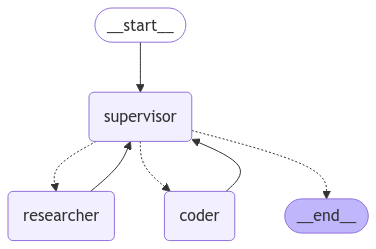

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = supervisor.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

**สิ่งที่ควรสังเกต:** ในตัวอย่างนี้ ตัวแทนย่อยทั้งสอง (researcher และ coder) สามารถเห็นงานของกันและกันได้ เนื่องจากความคืบหน้าทั้งหมดถูกบันทึกไว้ในรายการข้อความ สิ่งนี้ไม่ใช่วิธีเดียวในการจัดระเบียบนี้ ตัวแทนย่อยแต่ละตัวอาจมีความซับซ้อนมากขึ้น ตัวอย่างเช่น ตัวแทนย่อยอาจเป็นกราฟของตัวเองที่รักษาสถานะภายในและส่งออกเฉพาะสรุปของงานที่ทำเท่านั้น

หลังจากที่ตัวแทนแต่ละตัวดำเนินการ เราจะกำหนดเส้นทางกลับไปยังโหนดผู้ควบคุม ซึ่งจะตัดสินใจว่ามีงานเพิ่มเติมที่ต้องทำหรือไม่ และควรมอบหมายงานนั้นให้กับตัวแทนใด หากเป็นเช่นนั้น การกำหนดเส้นทางนี้ไม่ใช่ข้อกำหนดที่ยากสำหรับสถาปัตยกรรมนี้ เราสามารถให้ตัวแทนย่อยแต่ละตัวตัดสินใจว่าควรส่งออกผลลัพธ์โดยตรงไปยังผู้ใช้หรือไม่ ในการทำเช่นนั้น เราจะแทนที่ขอบคงที่ระหว่าง ตัวอย่างเช่น researcher และ supervisor ด้วยขอบที่มีเงื่อนไข (ซึ่งจะอ่านคีย์สถานะบางอย่างที่อัปเดตโดย researcher)

# Hierarchical Architecture

In [ ]:
import operator
from typing import TypedDict, Annotated, Literal, Sequence

# Langchain/Langgraph imports (ensure you have langchain and langgraph installed)
# pip install langchain langchain_openai langgraph tavily-python
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END

# Optional: For real LLM decision making (replace simple logic if needed)
# from langchain_core.pydantic_v1 import BaseModel

# --- Define the State ---
# This dictionary holds the information passed between nodes.
class HierarchicalAgentState(TypedDict):
    query: str              # The initial user request
    supervisor_decision: Literal["route_to_a", "route_to_b", "error"] # Decision from top supervisor
    result_a: str | None    # Result from MidLevelAgentA
    result_b: str | None    # Result from MidLevelAgentB
    final_result: str       # The final aggregated result

# --- Define Nodes (as functions) ---

# 1. Top Supervisor Node
#    (Using simple logic here; could be an LLM call with structured output)
def top_supervisor_node(state: HierarchicalAgentState) -> HierarchicalAgentState:
    """Decides which mid-level agent to route the query to."""
    print("--- Top Supervisor ---")
    query = state['query']
    print(f"Query: {query}")
    decision: Literal["route_to_a", "route_to_b", "error"]
    if "alpha" in query.lower():
        print("Decision: Route to Mid-Level Agent A")
        decision = "route_to_a"
    elif "beta" in query.lower():
        print("Decision: Route to Mid-Level Agent B")
        decision = "route_to_b"
    else:
        print("Decision: Cannot determine route")
        decision = "error" # Or handle error appropriately

    return {"supervisor_decision": decision, "result_a": None, "result_b": None} # Reset results

# 2. Mid-Level Agent A Node (Simulated work)
def mid_level_agent_a_node(state: HierarchicalAgentState) -> HierarchicalAgentState:
    """Performs Task A."""
    print("--- Mid-Level Agent A ---")
    query = state['query']
    # Simulate processing related to "alpha"
    result = f"Processed query '{query}' using ALPHA protocol."
    print(f"Result: {result}")
    return {"result_a": result}

# 3. Mid-Level Agent B Node (Simulated work)
def mid_level_agent_b_node(state: HierarchicalAgentState) -> HierarchicalAgentState:
    """Performs Task B."""
    print("--- Mid-Level Agent B ---")
    query = state['query']
    # Simulate processing related to "beta"
    result = f"Processed query '{query}' using BETA framework."
    print(f"Result: {result}")
    return {"result_b": result}

# 4. Aggregator Node
def aggregator_node(state: HierarchicalAgentState) -> HierarchicalAgentState:
    """Collects results and prepares the final output."""
    print("--- Aggregator ---")
    final_result = "No result generated."
    if state.get("result_a"):
        final_result = f"Final Output from A: {state['result_a']}"
    elif state.get("result_b"):
        final_result = f"Final Output from B: {state['result_b']}"
    elif state['supervisor_decision'] == "error":
         final_result = "Error: Could not determine appropriate processing path."

    print(f"Final Result: {final_result}")
    return {"final_result": final_result}

# --- Define Conditional Edges ---
def route_based_on_decision(state: HierarchicalAgentState) -> Literal["mid_level_agent_a", "mid_level_agent_b", "aggregator"]:
    """Determines the next node based on the supervisor's decision."""
    print("--- Routing ---")
    decision = state['supervisor_decision']
    if decision == "route_to_a":
        print("Routing to Agent A")
        return "mid_level_agent_a"
    elif decision == "route_to_b":
        print("Routing to Agent B")
        return "mid_level_agent_b"
    else: # Handle error or unexpected cases
        print("Routing directly to Aggregator (Error case)")
        return "aggregator" # Go directly to aggregator to report the error

# --- Build the Graph ---
workflow = StateGraph(HierarchicalAgentState)

# Add nodes
workflow.add_node("top_supervisor", top_supervisor_node)
workflow.add_node("mid_level_agent_a", mid_level_agent_a_node)
workflow.add_node("mid_level_agent_b", mid_level_agent_b_node)
workflow.add_node("aggregator", aggregator_node)

# Define edges
workflow.set_entry_point("top_supervisor")

# Conditional edge from supervisor to mid-level agents or aggregator
workflow.add_conditional_edges(
    "top_supervisor",
    route_based_on_decision,
    {
        "mid_level_agent_a": "mid_level_agent_a",
        "mid_level_agent_b": "mid_level_agent_b",
        "aggregator": "aggregator", # Route directly if decision was error
    }
)

# Edges from mid-level agents to the aggregator
workflow.add_edge("mid_level_agent_a", "aggregator")
workflow.add_edge("mid_level_agent_b", "aggregator")

# The aggregator node leads to the end
workflow.add_edge("aggregator", END)

# Compile the graph
app = workflow.compile()

# --- Run the Graph ---

print("\n--- Running Graph with 'alpha' query ---")
inputs_a = {"query": "Please process the request for alpha team."}
result_a_run = app.invoke(inputs_a)
print("\nFinal State (A):", result_a_run)


print("\n\n--- Running Graph with 'beta' query ---")
inputs_b = {"query": "Need to execute the beta workflow."}
result_b_run = app.invoke(inputs_b)
print("\nFinal State (B):", result_b_run)


print("\n\n--- Running Graph with 'unknown' query ---")
inputs_c = {"query": "What is the weather today?"}
result_c_run = app.invoke(inputs_c)
print("\nFinal State (C):", result_c_run)


In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

image_bytes = app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)

display(Image(data=image_bytes))

# Summary
**สรุป**

บทนี้กล่าวถึงส่วนขยายที่สำคัญสองส่วนของสถาปัตยกรรมตัวแทน: การสะท้อนกลับ (Reflection) และสถาปัตยกรรมหลายตัวแทน (Multi-agent Architectures) บทนี้ยังได้กล่าวถึงวิธีการทำงานกับ subgraphs ใน LangGraph ซึ่งเป็นส่วนประกอบหลักสำหรับระบบหลายตัวแทน

ส่วนขยายเหล่านี้เพิ่มพลังให้กับสถาปัตยกรรมตัวแทน LLM มากขึ้น แต่ไม่ควรเป็นสิ่งแรกที่คุณคว้ามาเมื่อสร้างตัวแทนใหม่ สถานที่ที่ดีที่สุดในการเริ่มต้นมักจะเป็นสถาปัตยกรรมตรงไปตรงมาที่เราได้กล่าวถึงใน บทที่ 6

บทที่ 8 กลับมาที่การแลกเปลี่ยนระหว่างความน่าเชื่อถือ (Reliability) และความเป็นอิสระ (Agency) ซึ่งเป็นการตัดสินใจออกแบบที่สำคัญเมื่อสร้างแอปพลิเคชัน LLM ในปัจจุบัน สิ่งนี้มีความสำคัญอย่างยิ่งเมื่อใช้สถาปัตยกรรมตัวแทนหรือหลายตัวแทน เนื่องจากพลังของสถาปัตยกรรมเหล่านี้มาพร้อมกับค่าใช้จ่ายของความน่าเชื่อถือหากปล่อยทิ้งไว้โดยไม่ได้รับการตรวจสอบ หลังจากเจาะลึกลงไปว่าเหตุใดการแลกเปลี่ยนนี้จึงมีอยู่

**บทที่ 8 จะกล่าวถึงเทคนิคที่สำคัญที่สุดที่มีให้คุณเพื่อนำทางการตัดสินใจนั้น และในที่สุดก็ปรับปรุงแอปพลิเคชันและตัวแทน LLM ของคุณ**

